# Mini-Project
### Group 23
### Nick Friesen & Tim Ufer
### D7041E

## ResNet18 - Fashion MNIST Dataset

### Preparation

In [1]:
### Imports ###

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import StratifiedKFold

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Dataset Loading and Pre-Processing

The data is loaded using PyTorch torchvision. Because the images come in size 28x28, the pre-processing part only consists of tensorizing and normalizing the images. Resizing, center-cropping, etc. are not necessary. Grayscale (3) is done to extend the dimensions of the image to 3 dimensions (still grayscale). This way it can be put into the neural network.

In [2]:
### Dataset Loading ###

batch_size = 128

transform = transforms.Compose(
    [transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
testset = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


100%|██████████| 26421880/26421880 [00:01<00:00, 18504215.82it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 299341.04it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5472051.84it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9387946.52it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



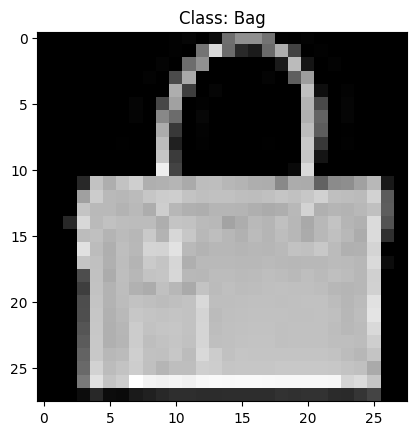

In [3]:
### Show random image ###

def imshow(sample):
    img = sample[0] / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap = "gray")
    plt.title(f"Class: {classes[sample[1]]}")
    plt.show()

# Get random training image
random_index = int(np.random.random()*len(trainset))
single_example = trainset[random_index]


# Show image
imshow(single_example)

The code above can be re-run to get random images and their respective label from the dataset.

### Hyperparameter search

In the following part, we are doing a simple hyperparameter search on the training data (without cross-validation). We train the network over 5 epochs and evaluate the accuracy that is achieved after the last epoch. This is not the scientific way to do it by any means, but it might give us an initial understanding of which hyperparameters to choose. We decided on the following parameters to investigate:

1.) Learning rates 

2.) Batch sizes

In [ ]:
### Load ResNet18 Model ###

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

In [ ]:
### Set device ###

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
### Define training loop ###

def parameter_train(batch_size, criterion, epochs):

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Loop through epochs
    for epoch in range(epochs):
        
        correct = 0
        total = 0
        
        #Training loop
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
    # Calculate accuracy after last epoch
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    return accuracy

In [ ]:
### Learning rates ###

## Set Hyperparameters ##

learning_rates = [0.0001, 0.001, 0.01, 0.1]
epochs = 5
batch_size = 64

# Set seeds for reproducability
seed = 23
torch.manual_seed(seed)
np.random.seed(seed)


for rate in learning_rates:
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=rate, momentum=0.9)

    accuracies = []
    
    accuracy = parameter_train(batch_size, criterion, epochs)
    
    accuracies.append(accuracy)


The resulting accuracies for different learning rates are:

0.0001: 87.50%

0.001: 90.62%

**0.01: 93.75%**

0.1: 87.50%

Hence, we will use a learning rate of 0.01 for the actual training and testing

In [ ]:
### Batch sizes ###

## Set Hyperparameters ##

learning_rate = 0.1
epochs = 5
batch_sizes = [128, 64, 32]

# Set seeds for reproducability
seed = 23
torch.manual_seed(seed)
np.random.seed(seed)


for size in batch_sizes:
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    accuracies = []
    
    accuracy = parameter_train(size, criterion, epochs)
    
    accuracies.append(accuracy)

The resulting accuracies for different batch sizes are:

128: 92.71%

64: 90.62%

32: 84.38%

Hence, we will use a batch size of 128 for the actual training and testing.

### Training

In [4]:
### Load ResNet18 Model ###

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained = False)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
### Set device ###

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
### Set Hyperparameters ###

learning_rate = 0.01
epochs = 10
num_folds = 5
batch_size = 128

# Set seeds for reproducability
seed = 23
torch.manual_seed(seed)
np.random.seed(seed)

In [7]:
### Set Loss and Optimizer ###

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### Training Loop

In [8]:
### Training Loop with Cross-Val ###

# Init k-fold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Loop through folds
for fold, (train_indices, val_indices) in enumerate(skf.split(np.zeros(len(trainset)), trainset.targets)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split dataset into train and validation sets
    train_set = torch.utils.data.Subset(trainset, train_indices)
    val_set = torch.utils.data.Subset(trainset, val_indices)

    # Create data loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    # Loop through epochs
    for epoch in range(epochs):
        
        #Training loop
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch {epoch + 1}/{epochs}, Validation Accuracy: {accuracy * 100:.2f}%")


Fold 1/5
Epoch 1/10, Validation Accuracy: 87.09%
Epoch 2/10, Validation Accuracy: 89.56%
Epoch 3/10, Validation Accuracy: 89.38%
Epoch 4/10, Validation Accuracy: 88.38%
Epoch 5/10, Validation Accuracy: 89.51%
Epoch 6/10, Validation Accuracy: 90.13%
Epoch 7/10, Validation Accuracy: 89.64%
Epoch 8/10, Validation Accuracy: 90.22%
Epoch 9/10, Validation Accuracy: 90.78%
Epoch 10/10, Validation Accuracy: 90.73%
Fold 2/5
Epoch 1/10, Validation Accuracy: 95.14%
Epoch 2/10, Validation Accuracy: 94.80%
Epoch 3/10, Validation Accuracy: 94.33%
Epoch 4/10, Validation Accuracy: 94.48%
Epoch 5/10, Validation Accuracy: 94.10%
Epoch 6/10, Validation Accuracy: 94.24%
Epoch 7/10, Validation Accuracy: 93.88%
Epoch 8/10, Validation Accuracy: 94.02%
Epoch 9/10, Validation Accuracy: 93.92%
Epoch 10/10, Validation Accuracy: 93.73%
Fold 3/5
Epoch 1/10, Validation Accuracy: 97.73%
Epoch 2/10, Validation Accuracy: 97.21%
Epoch 3/10, Validation Accuracy: 97.34%
Epoch 4/10, Validation Accuracy: 96.88%
Epoch 5/10,

### Testing loop

In [9]:
### Test loop ###

correct = 0
total = 0
predictions = []
targets = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

accuracy = correct / total
print(f'Accuracy on the test set: {100 * correct // total} %')

Accuracy on the test set: 91 %


The accuracy on the test set is: 91%

### Get metrics on test set

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

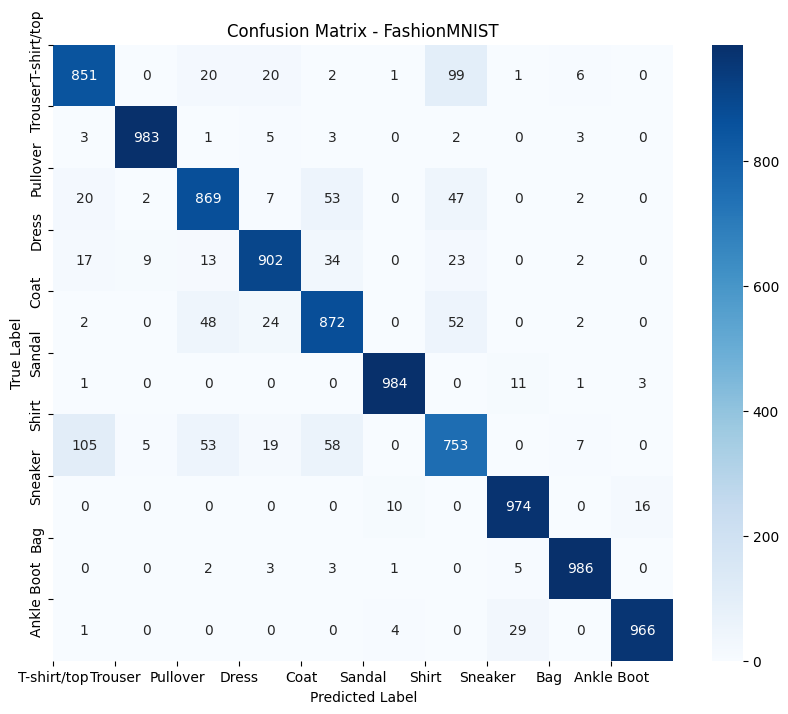

In [11]:
### Confusion matrix ###
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.title("Confusion Matrix - FashionMNIST")
plt.show()


It looks like the shirt class is the one that is being mis-predicted most often. On the opposite, the bag class is the one with the highest per-label accuracy.

In [12]:
### Classification Report ###

print("Classification Report:")
print(classification_report(targets, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.98      0.98      0.98      1000
           2       0.86      0.87      0.87      1000
           3       0.92      0.90      0.91      1000
           4       0.85      0.87      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.77      0.75      0.76      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.99      0.98      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



The classification report confirms the findings of the confusion matrix. Class 6 (shirt) has the lowest accuracy metrics, whereas class 8 (bag) has the highest accuracy metrics.